In [16]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [17]:
print(tf.__version__)

2.11.0


In [18]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 50s 0us/step


In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


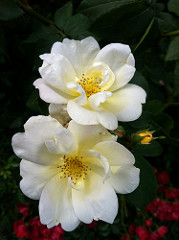

In [20]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

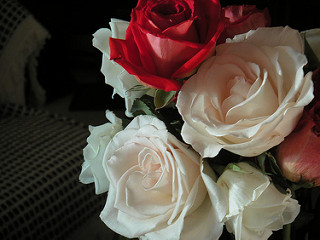

In [21]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [22]:
batch_size = 32
img_height = 180
img_width = 180

In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


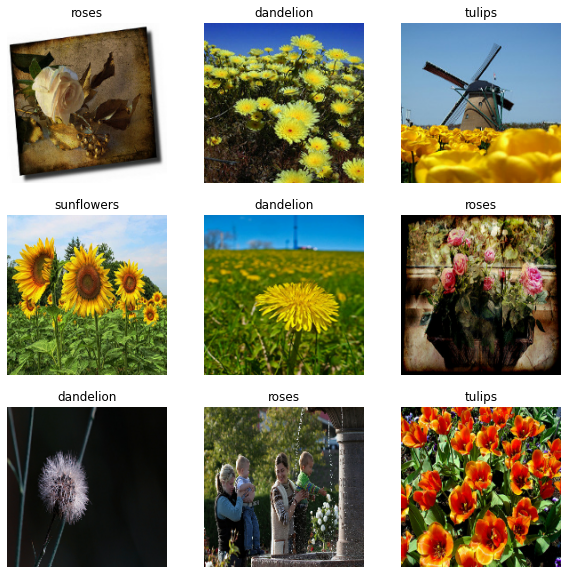

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [28]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 0.96902645


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [32]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [33]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 77s 809ms/step - loss: 1.2809 - accuracy: 0.4452 - val_loss: 1.0648 - val_accuracy: 0.5817
Epoch 2/10
92/92 [==============================] - 69s 747ms/step - loss: 1.0220 - accuracy: 0.5940 - val_loss: 0.9815 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 68s 743ms/step - loss: 0.8298 - accuracy: 0.6849 - val_loss: 0.9006 - val_accuracy: 0.6553
Epoch 4/10
92/92 [==============================] - 69s 756ms/step - loss: 0.6673 - accuracy: 0.7442 - val_loss: 1.0631 - val_accuracy: 0.6213
Epoch 5/10
92/92 [==============================] - 68s 741ms/step - loss: 0.5197 - accuracy: 0.8031 - val_loss: 1.1674 - val_accuracy: 0.6158
Epoch 6/10
92/92 [==============================] - 69s 748ms/step - loss: 0.4521 - accuracy: 0.8314 - val_loss: 1.1311 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 69s 753ms/step - loss: 0.2814 - accuracy: 0.9005 - val_loss: 1.4762 - val_accuracy: 0.6117

In [34]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [35]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\ASUS\\.keras\\datasets\\flower_photos\\dandelion\\4275776457_d04b597cfa_n.jpg'
b'C:\\Users\\ASUS\\.keras\\datasets\\flower_photos\\roses\\2535466393_6556afeb2f_m.jpg'
b'C:\\Users\\ASUS\\.keras\\datasets\\flower_photos\\tulips\\13509967925_eaaeefa396_m.jpg'
b'C:\\Users\\ASUS\\.keras\\datasets\\flower_photos\\tulips\\17282288501_e8738c9cfb_n.jpg'
b'C:\\Users\\ASUS\\.keras\\datasets\\flower_photos\\dandelion\\7116950607_49b19102ba_n.jpg'


In [36]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [37]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [38]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [39]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [40]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [41]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [42]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [43]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [44]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

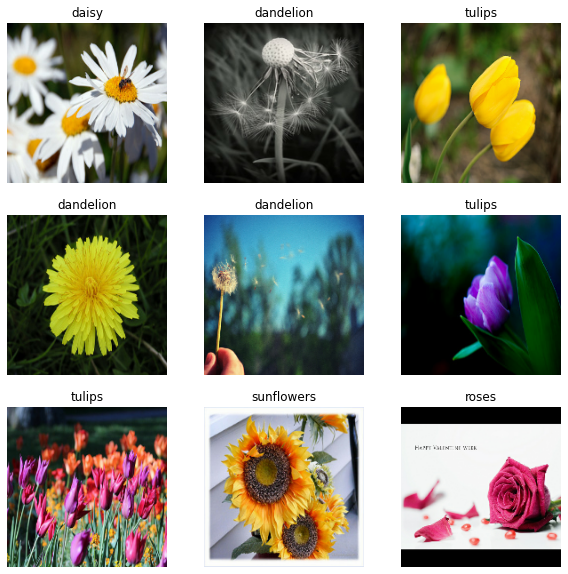

In [45]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [46]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 73s 787ms/step - loss: 0.3876 - accuracy: 0.8968 - val_loss: 0.3204 - val_accuracy: 0.9101
Epoch 2/10
92/92 [==============================] - 66s 720ms/step - loss: 0.1353 - accuracy: 0.9625 - val_loss: 0.3061 - val_accuracy: 0.9128
Epoch 3/10
92/92 [==============================] - 69s 755ms/step - loss: 0.0608 - accuracy: 0.9833 - val_loss: 0.3745 - val_accuracy: 0.8992
Epoch 4/10
92/92 [==============================] - 69s 755ms/step - loss: 0.0216 - accuracy: 0.9959 - val_loss: 0.4061 - val_accuracy: 0.9005
Epoch 5/10
92/92 [==============================] - 69s 755ms/step - loss: 0.0138 - accuracy: 0.9976 - val_loss: 0.3689 - val_accuracy: 0.8992
Epoch 6/10
92/92 [==============================] - 70s 758ms/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 0.3998 - val_accuracy: 0.9074
Epoch 7/10
92/92 [==============================] - 70s 762ms/step - loss: 0.0072 - accuracy: 0.9993 - val_loss: 0.4336 - val_accuracy: 0.9005

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [48]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset tf_flowers downloaded and prepared to C:\Users\ASUS\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [49]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


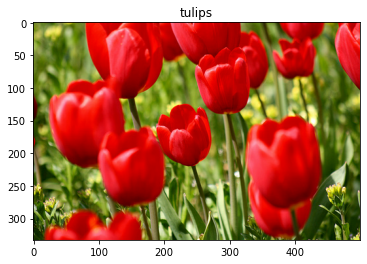

In [50]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [51]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [52]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [53]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [54]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [55]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

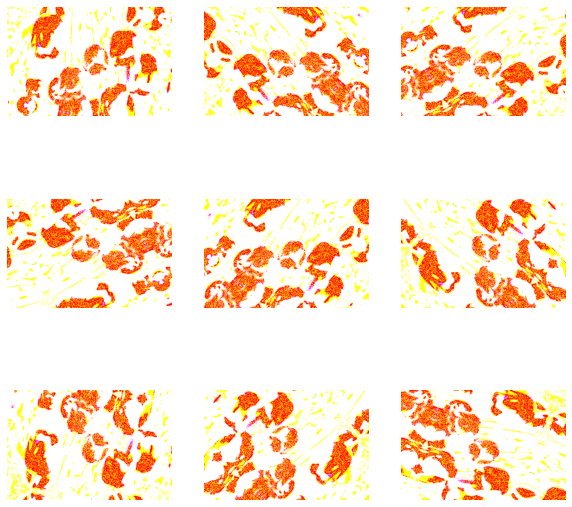

In [56]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [57]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

In [58]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [59]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [60]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [61]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [64]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,epochs=epochs)

Epoch 1/10
92/92 [==============================] - 58s 603ms/step - loss: 1.4054 - accuracy: 0.4094 - val_loss: 1.2104 - val_accuracy: 0.4796
Epoch 2/10
92/92 [==============================] - 60s 646ms/step - loss: 1.0719 - accuracy: 0.5732 - val_loss: 1.1099 - val_accuracy: 0.5504
Epoch 3/10
92/92 [==============================] - 60s 643ms/step - loss: 0.9736 - accuracy: 0.6243 - val_loss: 0.9897 - val_accuracy: 0.5804
Epoch 4/10
92/92 [==============================] - 61s 647ms/step - loss: 0.8907 - accuracy: 0.6577 - val_loss: 0.9421 - val_accuracy: 0.6076
Epoch 5/10
92/92 [==============================] - 63s 672ms/step - loss: 0.8223 - accuracy: 0.6792 - val_loss: 0.9873 - val_accuracy: 0.6158
Epoch 6/10
92/92 [==============================] - 66s 701ms/step - loss: 0.7789 - accuracy: 0.7061 - val_loss: 0.9651 - val_accuracy: 0.6185
Epoch 7/10
92/92 [==============================] - 66s 698ms/step - loss: 0.7394 - accuracy: 0.7129 - val_loss: 0.9635 - val_accuracy: 0.6267

In [65]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 2s 125ms/step - loss: 0.8065 - accuracy: 0.6403
Accuracy 0.640326976776123


In [66]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [67]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [68]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

In [69]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [70]:
_ = plt.imshow(RandomInvert()(image)[0])

In [71]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

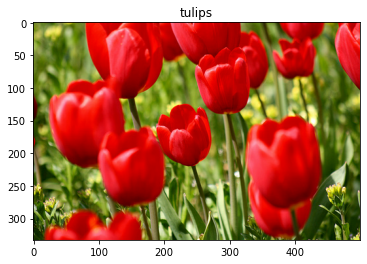

In [72]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [73]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

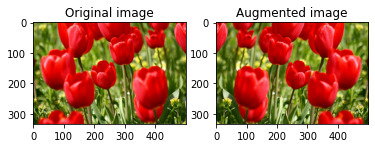

In [74]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

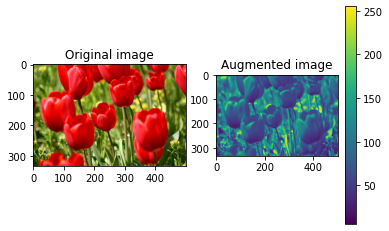

In [75]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

In [76]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

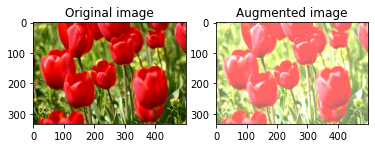

In [77]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

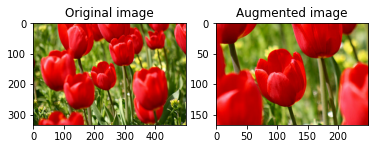

In [78]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)


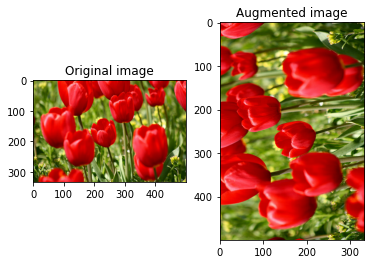

In [79]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

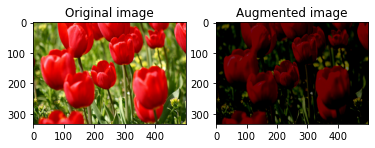

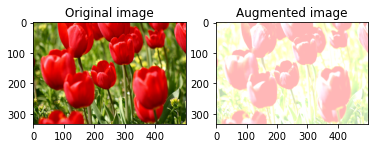

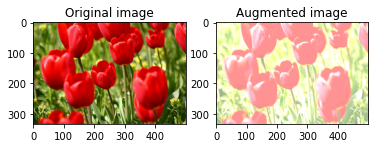

In [80]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

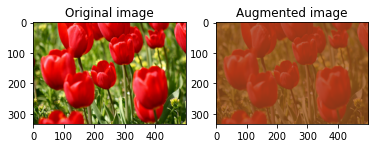

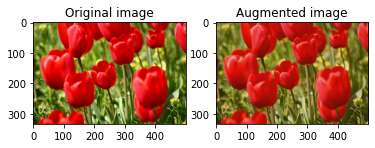

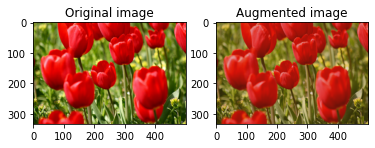

In [81]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

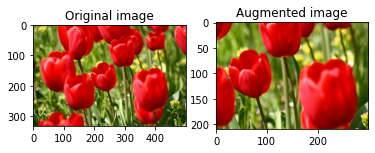

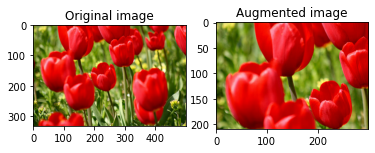

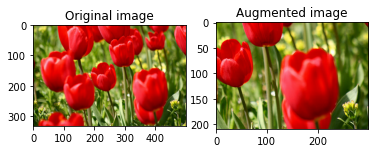

In [82]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

In [83]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [84]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [85]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

In [86]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


In [87]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [88]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [89]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [90]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [91]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

In [92]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [93]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [94]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)